<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#One-versus-All-Classifiers--(OvA-Classifiers)" data-toc-modified-id="One-versus-All-Classifiers--(OvA-Classifiers)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>One-versus-All Classifiers  (OvA Classifiers)</a></span><ul class="toc-item"><li><span><a href="#Parse-the-Data" data-toc-modified-id="Parse-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parse the Data</a></span></li><li><span><a href="#Classify-Each-Class-Seperately" data-toc-modified-id="Classify-Each-Class-Seperately-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classify Each Class Seperately</a></span></li><li><span><a href="#Append-All-Trained-Weights" data-toc-modified-id="Append-All-Trained-Weights-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Append All Trained Weights</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Evaluate the Model</a></span></li><li><span><a href="#Scaling-the-Input" data-toc-modified-id="Scaling-the-Input-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Scaling the Input</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Evaluate the Model</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# One-versus-All Classifiers  (OvA Classifiers)
In this chapter, we implement the OvA classification to classify the hand-written digits. We use the perceptron as a cost function. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from autograd import numpy as np
from autograd import grad
from autograd.misc.flatten import flatten_func
import copy

In [2]:
# compute C linear combinations of input point, one per classifier 
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:]) 
    return a.T

# def perceptron_exp(x, y, w): 
#     model_res = model(x, w) 
#     return y * model_res

# def softmax_approx(w):
#     log_cost = np.log(1 + np.exp(-1 * perceptron_exp(x, y, w))) 
#     cost = np.sum(log_cost)
#     return cost

#  # the convex softmax cost function
# def softmax(xp, w):
#     cost = np.sum(np.log(1 + np.exp(-y*model(xp,w)))) 
#     return cost/float(np.size(y))

# def softmax_global(w): 
#     return softmax(x, w)
def perceptron_exp(x, y, w): 
    model_res = model(x, w) 
    return y * model_res

def perceptron(w):
    perceptron_res = perceptron_exp(x, y, w) 
    # perceptron_res shape = (1, 100) 
    neg_perceptron = -1 * perceptron_res
    
    # create a zero vector
    zeros = np.zeros(perceptron_res.size).reshape(perceptron_res.shape)
    # choose the maximum element between the two vectors
    gw = np.maximum(zeros, neg_perceptron) 
    return np.sum(gw)/float(np.size(y))

# multiclass perceptron
lam = 10**-5 # our regularization paramter 
def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))] 
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    # print("a", a, "b", b, "cost", cost)
    return cost/float(np.size(y))

# gradient descent function 
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

def get_histories(fn, max_its, w, min_alpha=3, max_alpha=1, alpha_scale=1):
    labels = []
    cost_histories = []
    weight_histories = []
    for i in range(max_alpha, min_alpha+1):
      alpha = 10**(-i) * alpha_scale
      labels.append(r'$\alpha=10^{-%s}$' % str(i))
      weight_hist, cost_hist = gradient_descent(fn, alpha, max_its, w)
      cost_histories.append(cost_hist)
      weight_histories.append(weight_hist)
    return cost_histories, weight_histories, labels

# cost function history plotter
def plot_cost_histories(cost_histories,labels): 
    # create figure
    plt.figure() # 1, figsize=(10, 6))  
    # loop over cost histories and plot each one
    for j in range(len(cost_histories)): 
        history = cost_histories[j] 
        label = labels[j] 
        xnum = len(history)
        x = list(range(xnum))
        plt.plot(history, label = label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def number_misclassification(y, yfit): 
    miss_count = 0
    miss_index = []
    for i in range(np.size(y)):
        if y[0][i] != yfit[i]: 
            miss_count += 1
            miss_index.append(i)
    return miss_count, miss_index

def misclassification(miss_index, y, yfit):
    for index in miss_index:
        print("y", y[0][index], "yfit", yfit[index])
        
def accuracy(miss_count, ysize): 
    return 1 - miss_count/float(ysize)

def get_yfit(x, w, fn): 
    yfit = fn(model(x, w)) 
    return yfit

## Parse the Data
We start by reading the train data, and parse it to set the input and its label.

In [3]:
df_train = pd.read_csv("./traindata.csv", dtype=np.uint8)

In [4]:
df_train.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [5]:
df_train.shape

(60000, 786)

In [6]:
df_imgs = df_train.drop(['label', 'id'], axis=1)
x_original = df_imgs.as_matrix().T

In [7]:
x_original.shape

(784, 60000)

In [8]:
y_original = df_train['label'].as_matrix()
y_original = y_original.reshape(1, 60000)
print("y_original shape: ", y_original.shape)

y_original shape:  (1, 60000)


In [9]:
# sample indices
# num_sample = 5000
# inds = np.random.permutation(y_original.shape[1])[:num_sample]
# x_sample = x_original[:,inds]
# y_sample = y_original[:,inds]

In [9]:
x = x_original
y = y_original
yset = list(set(y[0]))

N = x.shape[0]

ydata = copy.deepcopy(y)

## Classify Each Class Seperately
We classify one digit at a time by setting that label to one, and other digits to -1. From the cost history graph, we choose the trained weight when the learning rate is $10^{-3}$. Once we train the model with the data and the modified label, we will have the trained weights and store in the weight list. 

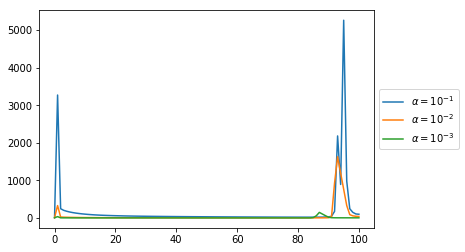

cost 2.42 y= 0 # miss 1244


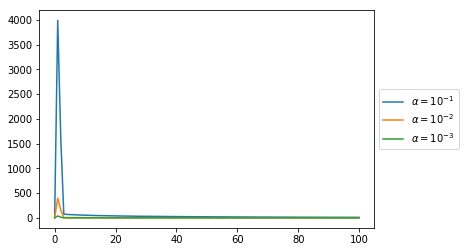

cost 0.14 y= 1 # miss 654


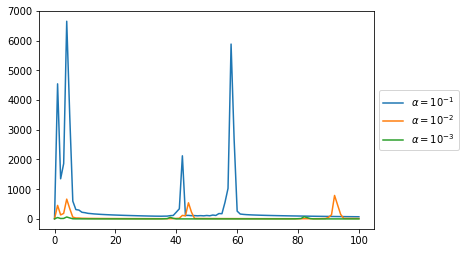

cost 1.23 y= 2 # miss 1556


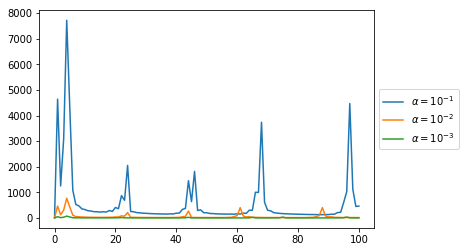

cost 2.01 y= 3 # miss 2777


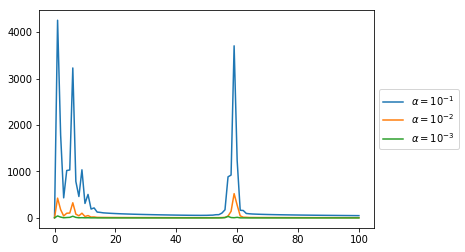

cost 0.52 y= 4 # miss 1175


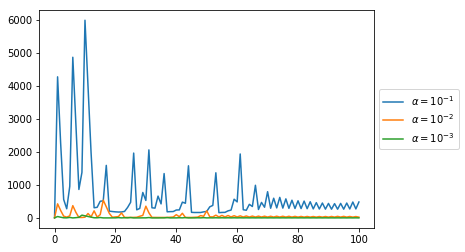

cost 2.66 y= 5 # miss 4439


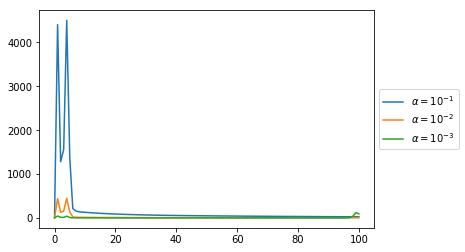

cost 91.11 y= 6 # miss 5918


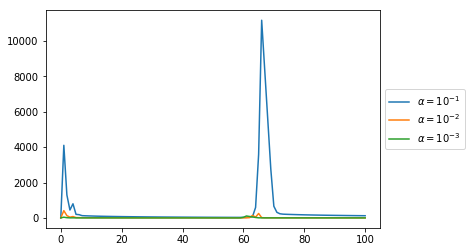

cost 1.13 y= 7 # miss 1156


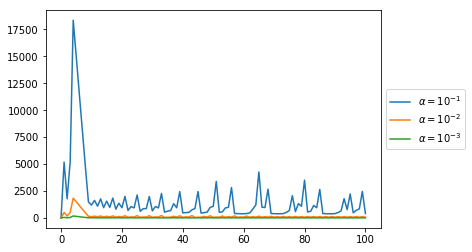

cost 7.20 y= 8 # miss 7732


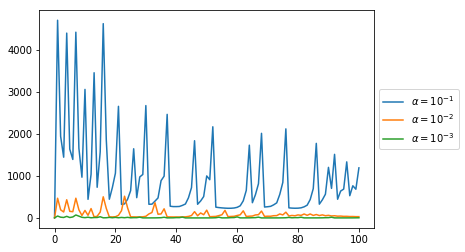

cost 5.49 y= 9 # miss 6737


In [11]:
w0 = 0.01 * np.random.randn(N + 1, 1)
weight_lst = []

for element, index in enumerate(yset):
    y = np.array(ydata, dtype=np.float_)
    y[element != y] = -1
    y[element == y] = 1
    cost_hist, weight_hist, labels = get_histories(perceptron, 
                                                   100, 
                                                   w0, min_alpha=3, max_alpha=1)
    plot_cost_histories(cost_hist, labels)
    weight_lst.append(weight_hist[-1][-1])
    yfit = get_yfit(x, weight_hist[-1][-1], np.sign)
    miss_count, _ = number_misclassification(y, yfit[0])
    print("cost %.2f" % (cost_hist[-1][-1]),
          "y=", element, 
          "# miss", miss_count) # , 
          # "weight", weight_hist[0][-1])

## Append All Trained Weights 
We append the trained weights and evaluate the model. The percent accuracy of this approach is 78%.

In [12]:
print("weight_lst len:", len(weight_lst))
print("weight_lst[0] shape:", weight_lst[0].shape)
w = np.empty((x.shape[0]+1, 0), dtype=float)

for weight in weight_lst:
    w = np.append(w, weight, axis=1)

print("w shape: ", w.shape)
yfit = model(x, w)
yfit = np.argmax(yfit, axis=0)
miss_count, _ = number_misclassification(ydata, yfit)
print("miss_count", miss_count)
print("accuracy", accuracy(miss_count, np.size(y)))

weight_lst len: 10
weight_lst[0] shape: (785, 1)
w shape:  (785, 10)
miss_count 14051
accuracy 0.7658166666666667


In [14]:
df_testdata = pd.read_csv("./testdata.csv", dtype=np.uint8)
df_testdata.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
df_testimgs = df_testdata.drop(['label', 'id'], axis=1)
xtest = df_testimgs.as_matrix().T
print("xtest shape:", xtest.shape)

xtest shape: (784, 10000)


In [16]:
ytest = df_testdata['label'].as_matrix()
ytest = ytest.reshape((10000, 1)).T
print("ytest shape:", ytest.shape)

ytest shape: (1, 10000)


## Evaluate the Model
We evaluate the model by the testing data.

In [16]:
yfit_test = model(xtest, w)
yfit_test = np.argmax(yfit_test, axis=0)
print("yfit_test shape:", yfit_test.shape)
print("yfit_test[0]:", yfit_test[0])
ytest[0][0]

miss_count, _ = number_misclassification(ytest, yfit_test)
raw_accuracy = accuracy(miss_count, np.size(ytest))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)

yfit_test shape: (10000,)
yfit_test[0]: 7
miss_count 2211
accuracy: 0.7789


## Scaling the Input
One of the techniques to improve the accuracy is to divide the input with its maximum value. This approach improves the accuracy in the SVM algorithm significantly. 

In [10]:
xmax = np.max(x_original)

x = x_original/xmax
y = y_original
yset = list(set(y[0]))

N = x.shape[0]

ydata = copy.deepcopy(y)

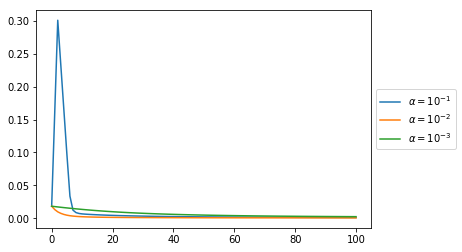

cost 0.00 y= 0 # miss 5349


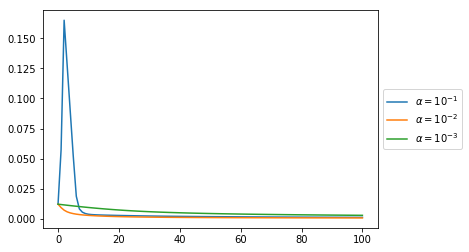

cost 0.00 y= 1 # miss 4951


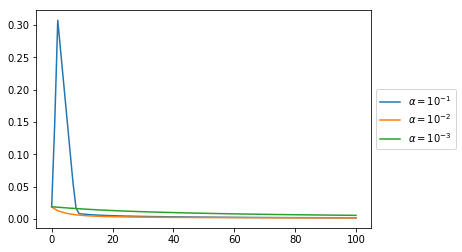

cost 0.01 y= 2 # miss 8649


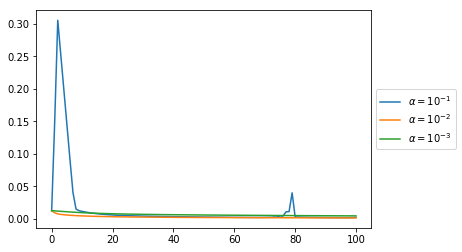

cost 0.00 y= 3 # miss 7062


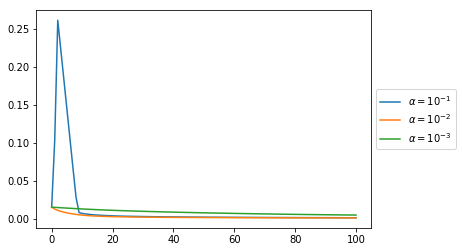

cost 0.00 y= 4 # miss 8921


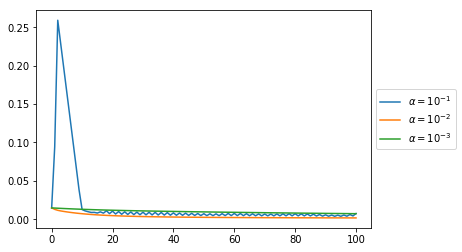

cost 0.01 y= 5 # miss 9189


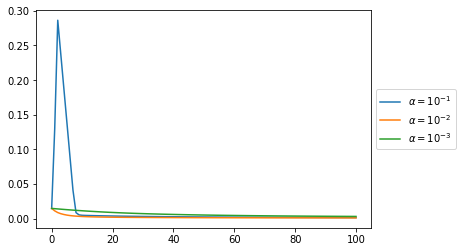

cost 0.00 y= 6 # miss 6002


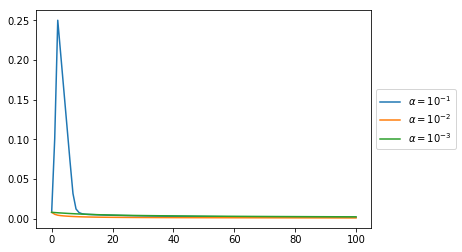

cost 0.00 y= 7 # miss 4808


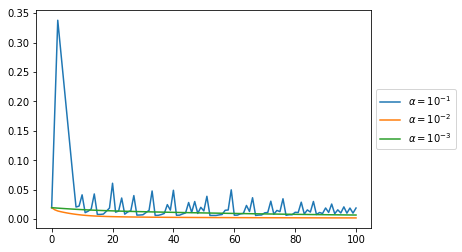

cost 0.01 y= 8 # miss 11238


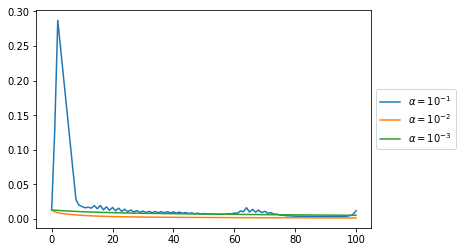

cost 0.01 y= 9 # miss 8837


In [11]:
w0 = 0.01 * np.random.randn(N + 1, 1)
weight_lst = []

for element, index in enumerate(yset):
    y = np.array(ydata, dtype=np.float_)
    y[element != y] = -1
    y[element == y] = 1
    cost_hist, weight_hist, labels = get_histories(perceptron, 
                                                   100, 
                                                   w0, min_alpha=3, max_alpha=1)
    plot_cost_histories(cost_hist, labels)
    weight_lst.append(weight_hist[-1][-1])
    yfit = get_yfit(x, weight_hist[-1][-1], np.sign)
    miss_count, _ = number_misclassification(y, yfit[0])
    print("cost %.2f" % (cost_hist[-1][-1]),
          "y=", element, 
          "# miss", miss_count) # , 
          # "weight", weight_hist[0][-1])

In [12]:
print("weight_lst len:", len(weight_lst))
print("weight_lst[0] shape:", weight_lst[0].shape)
w = np.empty((x.shape[0]+1, 0), dtype=float)

for weight in weight_lst:
    w = np.append(w, weight, axis=1)

print("w shape: ", w.shape)
yfit = model(x, w)
yfit = np.argmax(yfit, axis=0)
miss_count, _ = number_misclassification(ydata, yfit)
print("miss_count", miss_count)
print("accuracy", accuracy(miss_count, np.size(y)))

weight_lst len: 10
weight_lst[0] shape: (785, 1)
w shape:  (785, 10)
miss_count 11266
accuracy 0.8122333333333334


In [17]:
xtest_scale = xtest/xmax

## Evaluate the Model

In [18]:
yfit_test = model(xtest, w)
yfit_test = np.argmax(yfit_test, axis=0)
print("yfit_test shape:", yfit_test.shape)
print("yfit_test[0]:", yfit_test[0])
ytest[0][0]

miss_count, _ = number_misclassification(ytest, yfit_test)
raw_accuracy = accuracy(miss_count, np.size(ytest))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)

yfit_test shape: (10000,)
yfit_test[0]: 7
miss_count 1824
accuracy: 0.8176


## Discussion
Without the input scaling technique, the accuracy of the model is around 77. After we scale the input, the accuracy is raised to 81%. However, we adopt the gradient descent to optimize the cost function which is the local optimization and depends on the random values of the weight. If we use the global optimizer to find the global optimal point, it is possible that the accuracy will increase.